<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/notebooks/troposphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Download GPT2w and obtain pressure (mbar), temperature (°C) and humidity (%). 

2) Apply the Hopfield model, using the pressure, temperature and humidity found in exercise 1, with an elevation angle of 10°.

Resources: https://vmf.geo.tuwien.ac.at/



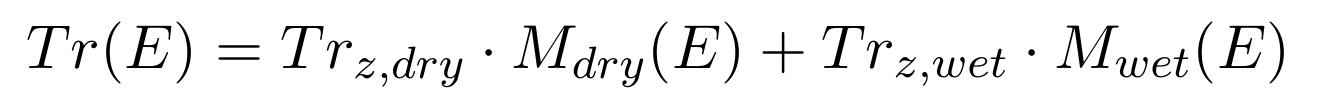

# Downloading and compiling GPT2

In [ ]:
!wget https://vmf.geo.tuwien.ac.at/codes/gpt2_1w.f 
!wget https://vmf.geo.tuwien.ac.at/codes/gpt2_1w.grd

--2021-11-05 23:10:20--  https://vmf.geo.tuwien.ac.at/codes/gpt2_1w.f
Resolving vmf.geo.tuwien.ac.at (vmf.geo.tuwien.ac.at)... 128.131.74.112
Connecting to vmf.geo.tuwien.ac.at (vmf.geo.tuwien.ac.at)|128.131.74.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16668 (16K) [text/plain]
Saving to: ‘gpt2_1w.f’

gpt2_1w.f           100%[===================>]  16.28K  --.-KB/s    in 0s      

2021-11-05 23:10:21 (103 MB/s) - ‘gpt2_1w.f’ saved [16668/16668]

--2021-11-05 23:10:21--  https://vmf.geo.tuwien.ac.at/codes/gpt2_1w.grd
Resolving vmf.geo.tuwien.ac.at (vmf.geo.tuwien.ac.at)... 128.131.74.112
Connecting to vmf.geo.tuwien.ac.at (vmf.geo.tuwien.ac.at)|128.131.74.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19245898 (18M)
Saving to: ‘gpt2_1w.grd’

gpt2_1w.grd         100%[===================>]  18.35M  14.6MB/s    in 1.3s    

2021-11-05 23:10:23 (14.6 MB/s) - ‘gpt2_1w.grd’ saved [19245898/19245898]



In [ ]:
!iconv -f ISO-8859-15 -t UTF-8 gpt2_1w.f > gpt2_1w_utf.f
!f2py3 -c -m gpt2_1w gpt2_1w_utf.f

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "gpt2_1w" sources
f2py options: []
f2py:> /tmp/tmp7gdcvrn2/src.linux-x86_64-3.7/gpt2_1wmodule.c
creating /tmp/tmp7gdcvrn2/src.linux-x86_64-3.7
Reading fortran codes...
	Reading file 'gpt2_1w_utf.f' (format:fix,strict)
Post-processing...
	Block: gpt2_1w
{}
In: :gpt2_1w:gpt2_1w_utf.f:gpt2_1w
vars2fortran: No typespec for argument "dmjd".
{'attrspec': ['dimension(64800)']}
In: :gpt2_1w:gpt2_1w_utf.f:gpt2_1w
vars2fortran: No typespec for argument "dlat".
{'attrspec': ['dimension(64800)']}
In: :gpt2_1w:gpt2_1w_utf.f:gpt2_1w
vars2fortran: No typespec for argument "dlon".
{'attrspec': ['dimension(64800)']}
In: :gpt2_1w:gpt2_1w_utf.f:gpt2_1w
vars2fortran: No typespec for argument "hell".
{}
In: :gpt2_1w:gpt2_1w_utf.f:gpt2_1w
vars2fo

#Importing libraries

In [ ]:
from gpt2_1w import gpt2_1w
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#!rm -rf spatialgeodesy
!git clone https://github.com/mauriciodev/spatialgeodesy.git
from spatialgeodesy import gnsstime

Cloning into 'spatialgeodesy'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (15/15), done.


# Input time

In [ ]:
epoch=np.datetime64('2021-05-30T23:45:00') 

# Running GPT2

In [ ]:
#These lon/lat vectors represent a GRID of 1x1 degrees that covers the entire planet.
#center of cell
dlon=360
dlat=180
lat=np.repeat(np.array(np.arange(89.5,-90.,-1.)),dlon)/180.*np.pi
lon=np.tile(np.array(np.arange(-179.5,180.,1.)),dlat)/180.*np.pi


In [ ]:
#Input vectors
#lon=np.array([-20]*64800)/180.*np.pi #this would be used for single site. longitude in radians [-pi:pi] or [0:2pi] (vector)
#lat=np.array([-20]*64800)/180.*np.pi #this would be used for single site. ellipsoidal latitude in radians [-pi/2:+pi/2] (vector)
mjd=gnsstime.getMJD(epoch) #modified Julian date (scalar, only one epoch per call is possible)
decimalTime=gnsstime.getSecsOfDay(epoch)/(24*60*60)
mjd+=decimalTime
nstat=64800 #number of stations in dlat, dlon, and hell maximum possible 64800
elipH=np.array([0.]*64800) #ellipsoidal height in m (vector)

#Output vectors
p=np.zeros_like(lat) #pressure in hPa (vector of length nstat) 
t=np.zeros_like(lat) #temperature in degrees Celsius (vector of length nstat)
dt=np.zeros_like(lat) #temperature lapse rate in degrees per km (vector of length nstat)
Tm=np.zeros_like(lat) #mean temperature of the water vapor in degrees Kelvin (vector of length nstat)
e=np.zeros_like(lat) #water vapor pressure in hPa (vector of length nstat)
ah=np.zeros_like(lat) #hydrostatic mapping function coefficient at zero height (VMF1) (vector of length nstat)
aw=np.zeros_like(lat) #wet mapping function coefficient (VMF1) (vector of length nstat)
la=np.zeros_like(lat) #water vapor decrease factor (vector of length nstat)
undu=np.zeros_like(lat) #geoid undulation in m (vector of length nstat)
gpt2_1w(mjd,lat,lon,elipH,nstat,0,p,t,dt,Tm,e,ah,aw,la,undu)

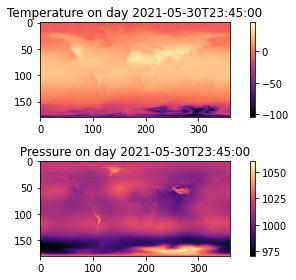

In [ ]:
fig, axs = plt.subplots(2, 1)
im=axs[0].imshow(np.reshape(t,(180,360)),  cmap=plt.get_cmap('magma'))
axs[0].set_title("Temperature on day {}".format(epoch))
fig.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.reshape(p,(180,360)),  cmap=plt.get_cmap('magma'))
axs[1].set_title("Pressure on day {}".format(epoch))
fig.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.show()

# Exercise

In [ ]:
#Change THIS
epoch=np.datetime64('2021-05-30T23:45:00') 
E=10 #Given by the exercise
siteLat=-22
siteLon=-55
height=0

In [ ]:
#F2PY requires that we allocate the entire vector, for some reason, but only one site is going to be computed.
mjd=gnsstime.getMJD(epoch) #Julian day
decimalTime=gnsstime.getSecsOfDay(epoch)/(24*60*60)
mjd+=decimalTime
nstat=1
lon=np.array([siteLon]*64800)/180.*np.pi #this would be used for single site
lat=np.array([siteLat]*64800)/180.*np.pi #this would be used for single site
elipH=np.array([height]*64800)
p=np.zeros_like(lat) #pressure in hPa (vector of length nstat) 
t=np.zeros_like(lat) #temperature in degrees Celsius (vector of length nstat)
dt=np.zeros_like(lat) #temperature lapse rate in degrees per km (vector of length nstat)
Tm=np.zeros_like(lat) #mean temperature of the water vapor in degrees Kelvin (vector of length nstat)
e=np.zeros_like(lat) #water vapor pressure in hPa (vector of length nstat)
ah=np.zeros_like(lat) #hydrostatic mapping function coefficient at zero height (VMF1) (vector of length nstat)
aw=np.zeros_like(lat) #wet mapping function coefficient (VMF1) (vector of length nstat)
la=np.zeros_like(lat) #water vapor decrease factor (vector of length nstat)
undu=np.zeros_like(lat) #geoid undulation in m (vector of length nstat)
gpt2_1w(mjd,lat,lon,elipH,nstat,0,p,t,dt,Tm,e,ah,aw,la,undu)

In [ ]:
print("Modified Julian day:",mjd)
print("Pressure:",p[0])
print("Temperature:",t[0])
print("Humidity:",e[0]/p[0]*100)

Modified Julian day: 59364.989583333336
Pressure: 1015.8839367162325
Temperature: 23.52399240202957
Humidity: 1.9497332657957696


#Tropospheric delay components

In [ ]:
#Reading the values from GPT2
P0=p[0]
T0=t[0]+273.15
e0=e[0]
print("Pressure:", P0)
print("Temperature:",T0)
print("Water vapour pressure:", e0)

#Hopfield Model
Hw=11000
#Hw= 11000 - 44.44*np.fabs(siteLat) #use this for latitudes near the pole
 
Hh=40136+148.72*(T0-273.16)
Dzh=155.2*10e-8 *P0/T0*Hh
Dzw=155.2*10e-8 *(4810*e0)/(T0**2) *Hw
print("Dzh",Dzh)
print("Dzw",Dzw)

Pressure: 1015.8839367162325
Temperature: 296.67399240202957
Water vapour pressure: 19.807027056032027
Dzh 2.318843386814623
Dzw 0.18479483186617834


In [ ]:
mhE=1/np.sin((np.sqrt(E**2 + 6.25)/180*np.pi))
mwE=1/np.sin((np.sqrt(E**2 + 2.25)/180*np.pi))
print("mw(E):",mwE, "mh(E):",mhE)

mw(E): 5.6957094109910145 mh(E): 5.588604755820537


In [ ]:
Tr=mwE * Dzw + mhE * Dzh
print("Tropospheric delay:",Tr)

Tropospheric delay: 14.011636842517898


# Tropospheric delay maps

In [ ]:
dlon=360
dlat=180
E=10 #Given by the exercise

lat=np.repeat(np.array(np.arange(89.5,-90.,-1.)),dlon)/180.*np.pi
lon=np.tile(np.array(np.arange(-179.5,180.,1.)),dlat)/180.*np.pi

#Temperature, pressure and water vapor model
mjd=gnsstime.getMJD(epoch) #Julian day
nstat=64800
elipH=np.array([height]*64800)
p=np.zeros_like(lat) #pressure in hPa (vector of length nstat) 
t=np.zeros_like(lat) #temperature in degrees Celsius (vector of length nstat)
dt=np.zeros_like(lat) #temperature lapse rate in degrees per km (vector of length nstat)
Tm=np.zeros_like(lat) #mean temperature of the water vapor in degrees Kelvin (vector of length nstat)
e=np.zeros_like(lat) #water vapor pressure in hPa (vector of length nstat)
ah=np.zeros_like(lat) #hydrostatic mapping function coefficient at zero height (VMF1) (vector of length nstat)
aw=np.zeros_like(lat) #wet mapping function coefficient (VMF1) (vector of length nstat)
la=np.zeros_like(lat) #water vapor decrease factor (vector of length nstat)
undu=np.zeros_like(lat) #geoid undulation in m (vector of length nstat)
gpt2_1w(mjd,lat,lon,elipH,nstat,0,p,t,dt,Tm,e,ah,aw,la,undu)


#Mapping function
P0=p
T0=t+273.15
e0=e
Hw=11000
#Hw= 11000 - 44.44*np.fabs(siteLat) #use this for latitudes near the pole
Hh=40136+148.72*(T0-273.16)
Dzh=155.2*10e-8 *P0/T0*Hh
Dzw=155.2*10e-8 *(4810*e0)/(T0**2) *Hw


mhE=1/np.sin((np.sqrt(E**2 + 6.25)/180*np.pi))
mwE=1/np.sin((np.sqrt(E**2 + 2.25)/180*np.pi))
Wet=mwE*Dzw
Dry=mhE*Dzh
Tr=Wet+Dry
print("Dzh",Dzh)
print("Dry",Dry)
print("Dzw",Dzw)
print("Wet",Wet)



Dzh [2.32104537 2.32108538 2.32107298 ... 2.3406977  2.34070116 2.34069329]
Dry [12.97140522 12.9716288  12.97155948 ... 13.08123427 13.08125362
 13.08120964]
Dzw [0.04760677 0.0476076  0.04760737 ... 0.00241334 0.00241695 0.0024501 ]
Wet [0.27115432 0.27115905 0.27115776 ... 0.01374571 0.01376627 0.01395508]


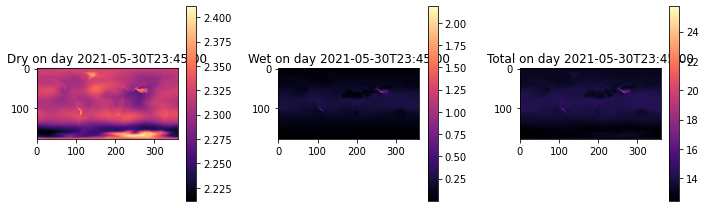

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10,3)
im=axs[0].imshow(np.reshape(Dzh,(180,360)),  cmap=plt.get_cmap('magma'))
axs[0].set_title("Dry on day {}".format(epoch))
fig.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.reshape(Dzw,(180,360)),  cmap=plt.get_cmap('magma'))
axs[1].set_title("Wet on day {}".format(epoch))
fig.colorbar(im, ax=axs[1])
im=axs[2].imshow(np.reshape(Tr,(180,360)),  cmap=plt.get_cmap('magma'))
axs[2].set_title("Total on day {}".format(epoch))
fig.colorbar(im, ax=axs[2])
plt.tight_layout()
plt.show()